In [1]:
import os, sys
sys.path.append("../src/")
from collections import Counter
from datetime import datetime
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE, ADASYN
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import visualizations as visu
import language as lang
import evaluation as eval

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import InputLayer, Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow_hub as hub

tf.config.run_functions_eagerly(True)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Descrição do modelo
- Proprocessamento melhorado: Melhorias NLP, TfidfVectorizer com ngram_range de 1 a 3 e 500 features tfidf;
- Features adicionais além do texto do post;
- Seleção de features com baixa variância;
- Reequilibrio das classes com SMOTE;
- Modelo de NN com Hold-out.

In [2]:
print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TF version: 2.5.0
GPU is available
Num GPUs Available:  1


In [3]:
def reset_random_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

# make some random data
reset_random_seeds()

## Loading data

In [4]:
# Loading the data
df_train = pd.read_csv('../data/Social Bias Frames/SBIC.v2.trn.csv')
df_valid = pd.read_csv('../data/Social Bias Frames/SBIC.v2.dev.csv')
df_test = pd.read_csv('../data/Social Bias Frames/SBIC.v2.tst.csv')

## Data Preparation:

In [5]:
target_col = 'targetCategory'

In [6]:
print('train data:', df_train.shape)
print('valid data:', df_valid.shape)
print('test data:', df_test.shape)

df_train[target_col].value_counts(dropna=False)

train data: (112900, 19)
valid data: (16738, 19)
test data: (17501, 19)


NaN         70406
race        14987
gender      10872
culture      8843
victim       2680
disabled     2350
social       1730
body         1032
Name: targetCategory, dtype: int64

In [7]:
# Dropping nan values:
df_train = df_train.dropna(subset=[target_col]).reset_index(drop=True)
df_valid = df_valid.dropna(subset=[target_col]).reset_index(drop=True)
df_test = df_test.dropna(subset=[target_col]).reset_index(drop=True)

print('train data:', df_train.shape)
print('valid data:', df_valid.shape)
print('test data:', df_test.shape)

train data: (42494, 19)
valid data: (8166, 19)
test data: (9200, 19)


In [8]:
# Concating train and valid dataframes and splitting X and y arrays:
X_train = df_train.drop(columns=[target_col])
y_train = df_train[[target_col]]

X_valid = df_valid.drop(columns=[target_col])
y_valid = df_valid[[target_col]]

X_test = df_test.drop(columns=[target_col])
y_test = df_test[[target_col]]

print('train data:', X_train.shape)
print('valid data:', X_valid.shape)
print('test data:', X_test.shape)

train data: (42494, 18)
valid data: (8166, 18)
test data: (9200, 18)


In [9]:
# Encoding the y targets:
le = LabelEncoder()
y_train[target_col] = le.fit_transform(y_train[target_col])
y_valid[target_col] = le.transform(y_valid[target_col])
y_test[target_col] = le.transform(y_test[target_col])

<ipython-input-9-cbefa2631099>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[target_col] = le.fit_transform(y_train[target_col])
<ipython-input-9-cbefa2631099>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_valid[target_col] = le.transform(y_valid[target_col])
<ipython-input-9-cbefa2631099>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

## Pre-processing

In [10]:
# Creating some features
X_train['post_length'] = X_train['post'].apply(lambda x: len(x))
X_train['post_length_no_spaces'] = X_train['post'].apply(lambda x: len(x) - x.count(" "))

X_valid['post_length'] = X_valid['post'].apply(lambda x: len(x))
X_valid['post_length_no_spaces'] = X_valid['post'].apply(lambda x: len(x) - x.count(" "))

X_test['post_length'] = X_test['post'].apply(lambda x: len(x))
X_test['post_length_no_spaces'] = X_test['post'].apply(lambda x: len(x) - x.count(" "))

In [11]:
# Encoding text columns:
en_stp_words = stopwords.words('english')
max_features = 500

def column_vectorizer(df_train, df_valid, df_test, col, analyzer, max_features=100, stop_words=stopwords.words('english')):
    corpus = df_train[col].values
    vectorizer = TfidfVectorizer(analyzer=analyzer, max_features=max_features)
    vectorizer.fit(corpus)

    df_train_tfidf = vectorizer.transform(df_train[col])
    tfidf_cols = [f'tfidf_{col}_{i}' for i in range(df_train_tfidf.shape[1])]
    df_train_tfidf = pd.DataFrame(df_train_tfidf.toarray(), columns=tfidf_cols)
    df_train = pd.concat([df_train, df_train_tfidf], axis=1)

    df_valid_tfidf = vectorizer.transform(df_valid[col])
    df_valid_tfidf = pd.DataFrame(df_valid_tfidf.toarray(), columns=tfidf_cols)
    df_valid = pd.concat([df_valid, df_valid_tfidf], axis=1)
    
    df_test_tfidf = vectorizer.transform(df_test[col])
    df_test_tfidf = pd.DataFrame(df_test_tfidf.toarray(), columns=tfidf_cols)
    df_test = pd.concat([df_test, df_test_tfidf], axis=1)
    
    return df_train, df_valid, df_test, tfidf_cols
    
# post text:
X_train, X_valid, X_test, tfidf_cols = column_vectorizer(X_train, X_valid, X_test, 'post', analyzer=lang.clean_text_stem,
                                                max_features=max_features, stop_words=en_stp_words)


In [12]:
X_train

,whoTarget,intentYN,sexYN,sexReason,offensiveYN,annotatorGender,annotatorMinority,sexPhrase,speakerMinorityYN,WorkerId,...,tfidf_post_490,tfidf_post_491,tfidf_post_492,tfidf_post_493,tfidf_post_494,tfidf_post_495,tfidf_post_496,tfidf_post_497,tfidf_post_498,tfidf_post_499
0,1.0,1.0,0.0,NaN,1.0,man,NaN,NaN,0.0,-500114755446676507,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,NaN,1.0,man,NaN,NaN,0.0,-500114755446676507,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,NaN,1.0,woman,NaN,NaN,0.0,7912096326098817047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,NaN,1.0,woman,NaN,NaN,0.0,7912096326098817047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,NaN,1.0,woman,NaN,NaN,0.0,7912096326098817047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42489,1.0,1.0,0.0,NaN,1.0,man,NaN,NaN,0.0,-5313160613530610330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42490,1.0,1.0,0.0,NaN,1.0,man,NaN,NaN,0.0,-5313160613530610330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42491,1.0,1.0,0.0,NaN,1.0,woman,NaN,NaN,0.0,1869048359460155317,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42492,1.0,1.0,0.0,NaN,1.0,woman,NaN,NaN,0.0,1869048359460155317,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Encoding other columns:

# Features groups:
cat_features = ['dataSource']
num_float_features = ['post_length', 'post_length_no_spaces']
passthrough_features = [] + tfidf_cols

# Features transformers:
cat_transformer = ('cat', Pipeline([('cat_imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='none')),
                                    ('one-hot', OneHotEncoder(handle_unknown='ignore'))]), cat_features)
num_float_transformer = ('num_float', Pipeline([('num_float_imputer', SimpleImputer(missing_values=np.nan, strategy='mean')), 
                                                ('num_float_scaler', MinMaxScaler()),]), num_float_features)
passthrough_transformer = ('passthrough', 'passthrough', passthrough_features)

transformers = [cat_transformer, num_float_transformer, passthrough_transformer]
feat_encoding = ColumnTransformer(transformers, remainder='drop')

In [14]:
# Pre-processing pipeline:
preprocessor = Pipeline([('features encoding', feat_encoding),
                         ('feature selection var', VarianceThreshold(threshold=1e-3))])

In [15]:
X_train_encoded = preprocessor.fit_transform(X_train)
X_valid_encoded = preprocessor.transform(X_valid.loc[:, X_train.columns])
X_test_encoded = preprocessor.transform(X_test.loc[:, X_train.columns])

In [16]:
print('X_train:', X_train.shape)
print('X_train_encoded:', X_train_encoded.shape)

X_train: (42494, 520)
X_train_encoded: (42494, 471)


## Dealing with the imbalance:

In [17]:
print(sorted(Counter(y_train[target_col]).items()))
X_train_encoded, y_train_ = SMOTE().fit_resample(X_train_encoded, y_train[target_col])
print(sorted(Counter(y_train_).items()))

[(0, 1032), (1, 8843), (2, 2350), (3, 10872), (4, 14987), (5, 1730), (6, 2680)]
[(0, 14987), (1, 14987), (2, 14987), (3, 14987), (4, 14987), (5, 14987), (6, 14987)]


In [18]:
enc = OneHotEncoder(categories=[le.transform(le.classes_)], handle_unknown='ignore')
y_train_encoded = enc.fit_transform(y_train_.values.reshape(-1, 1)).toarray()
y_valid_encoded = enc.fit_transform(y_valid.values.reshape(-1, 1)).toarray()

## Building the NN Model

In [19]:
n_classes = le.classes_.shape[0]
def build_model(input_shape, n_classes=10):
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(n_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

    return model

model = build_model(input_shape=(X_train_encoded.shape[1],), n_classes=n_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              483328    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 9

## Model Training

In [20]:
epochs = 100
batch_size = 256
learning_rate = 1e-4
patience = 20
model_tag = f'{datetime.now().year}-{datetime.now().month}-{datetime.now().day}-{datetime.now().hour}-{datetime.now().minute}-{datetime.now().second}'
weights_filepath = f"./weights/weights_{model_tag}.h5"

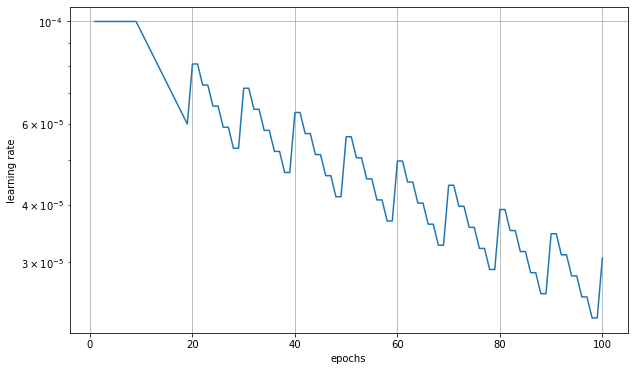

In [21]:
def scheduler(epoch, lr):
    if epoch < 10:
        pass
    elif epoch < 20:
        lr = lr*0.95
    elif epoch%2 == 0 and not epoch%10==0:
        lr = lr*0.9
    elif epoch%10== 0:
        lr = lr*1.35
    return max([lr, 1e-6])

def plot_lr_scheduler(scheduler, lr_start=1e-2, n_epochs=100):

    epochs_array = np.arange(1, n_epochs+1, 1)
    lr_array = [lr_start]
    for ep in epochs_array:
        lr_array.append(scheduler(ep, lr=lr_array[-1]))
    lr_array = lr_array[1:]

    plt.figure(figsize=(10,6))
    plt.plot(epochs_array, lr_array)
    plt.xlabel('epochs')
    plt.ylabel('learning rate')
    plt.yscale('log')
    plt.grid()
    plt.show()

plot_lr_scheduler(scheduler, lr_start=learning_rate, n_epochs=epochs)

In [22]:
callbacks = [ModelCheckpoint(weights_filepath, monitor='val_acc', mode='max',
                             verbose=1, save_best_only=True),
             EarlyStopping(monitor='val_acc', mode='max', patience=patience),
             LearningRateScheduler(scheduler, verbose=1)]

# optimizer = tf.keras.optimizers.RMSprop(lr = learning_rate)
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [23]:
model.fit(X_train_encoded, y_train_encoded,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid_encoded, y_valid_encoded),
          callbacks=callbacks,
          verbose=1)

model.load_weights(weights_filepath)

C:\Users\weldl\Miniconda3\envs\work\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
410/410 [==============================] - 9s 21ms/step - loss: 1.3750 - acc: 0.5714 - val_loss: 0.9672 - val_acc: 0.7149

Epoch 00001: val_acc improved from -inf to 0.71492, saving model to ./weights\weights_2022-6-25-12-51-20.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
410/410 [==============================] - 8s 21ms/step - loss: 0.8222 - acc: 0.7649 - val_loss: 0.9672 - val_acc: 0.7177

Epoch 00002: val_acc improved from 0.71492 to 0.71773, saving model to ./weights\weights_2022-6-25-12-51-20.h5
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
410/410 [==============================] - 11s 26ms/step - loss: 0.6681 - acc: 0.8140 - val_loss: 0.9377 - val_acc: 0.7311

Epoch 00003: val_acc improved from 0.71773 to 0.73108, saving model to ./weights\weights_2022-6-25-12-51-20.h5
Epoch 4/1

In [24]:
model_hist = pd.DataFrame(model.history.history)
model_hist.head()

,loss,acc,val_loss,val_acc,lr
0,1.374994,0.571371,0.967192,0.714916,0.0001
1,0.822175,0.764872,0.967184,0.717732,0.0001
2,0.668059,0.813953,0.937720,0.731080,0.0001
3,0.567817,0.845428,0.932486,0.735734,0.0001
4,0.495477,0.865464,0.941633,0.734999,0.0001


In [25]:
def plot_model_hist(historic, title=''):

    plt.figure(figsize=(15, 5))

    plt.subplot(1,2,1)
    plt.title(title+' loss')
    plt.plot(historic['loss'], label='train loss')
    plt.plot(historic['val_loss'], label='valid. loss')
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")

    plt.subplot(1,2,2)
    plt.title(title+' acc')
    plt.plot(historic['acc'], label='train acc')
    plt.plot(historic['val_acc'], label='valid. acc')
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("acc")

    plt.show()

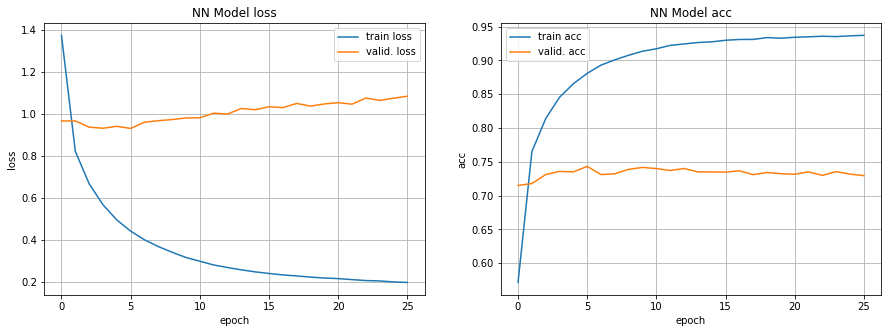

In [26]:
plot_model_hist(model_hist, 'NN Model')

## Evaluating the model

In [27]:
TARGET_NAMES = le.classes_
TARGET_NAMES

array(['body', 'culture', 'disabled', 'gender', 'race', 'social',
       'victim'], dtype=object)

C:\Users\weldl\Miniconda3\envs\work\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


Classes evaluated: ['body', 'culture', 'disabled', 'gender', 'race', 'social', 'victim']
Correctly classified......: 6822/9200
Accuracy (simple) ........: 0.74
Balanced acc.  ...........: 0.58
Balanced acc. (adjusted)..: 0.51
Acc. norm (Recall avgs) ..: 0.58
Precision = tp / (tp + fp): [0.32 0.7  0.44 0.81 0.9  0.4  0.23] -> accuracy of positive predictions
Recall    = tp / (tp + fn): [0.45 0.76 0.45 0.8  0.8  0.43 0.36] -> sensibility (true positive rate)
F1 score .................: [0.37 0.73 0.45 0.8  0.85 0.41 0.28] -> harmonic mean


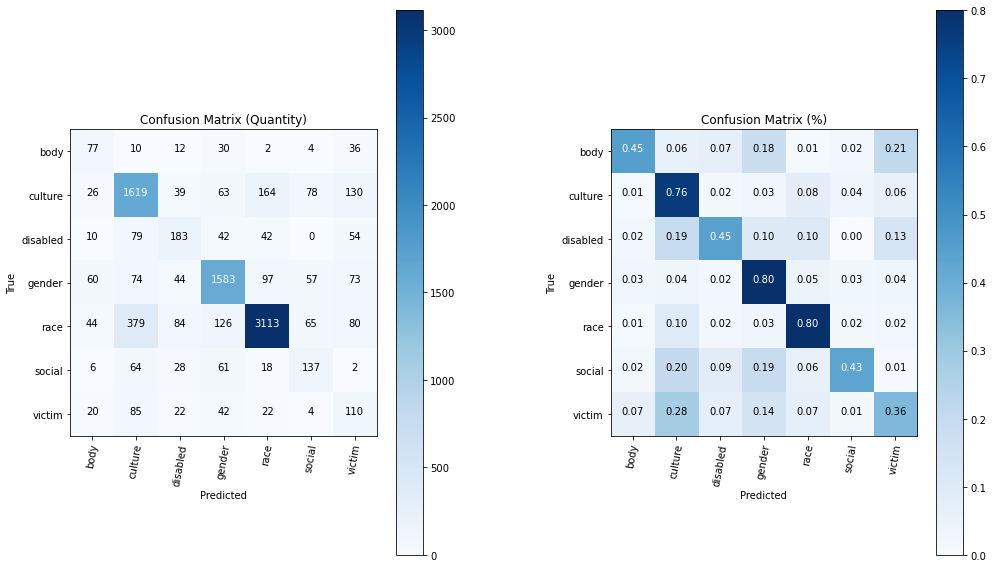

,accuracy,balanced_accuracy,balanced_accuracy adjusted,precision,recall,f1_score
0,0.74,0.58,0.51,0.32,0.45,0.37
1,0.74,0.58,0.51,0.70,0.76,0.73
2,0.74,0.58,0.51,0.44,0.45,0.45
3,0.74,0.58,0.51,0.81,0.80,0.80
4,0.74,0.58,0.51,0.90,0.80,0.85
5,0.74,0.58,0.51,0.40,0.43,0.41
6,0.74,0.58,0.51,0.23,0.36,0.28


In [28]:
y_pred_test = np.argmax(model.predict(X_test_encoded), axis=1)
y_true_test = y_test[target_col].values

results = eval.performance_measures(y_true_test, y_pred_test, TARGET_NAMES)
results = pd.DataFrame(results)
results

../src\evaluation.py:149: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
../src\evaluation.py:150: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
../src\evaluation.py:152: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
../src\evaluation.py:153: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False


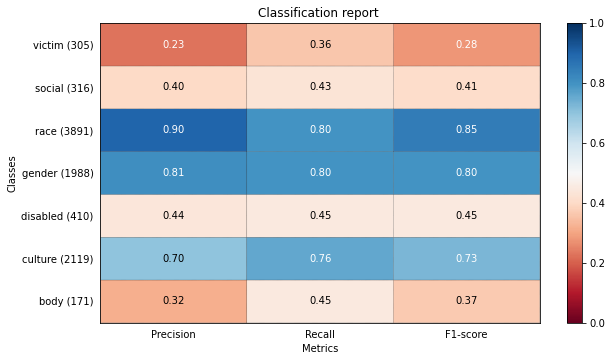

In [29]:
eval.plot_classification_report(classification_report(y_true_test, y_pred_test, target_names=TARGET_NAMES))